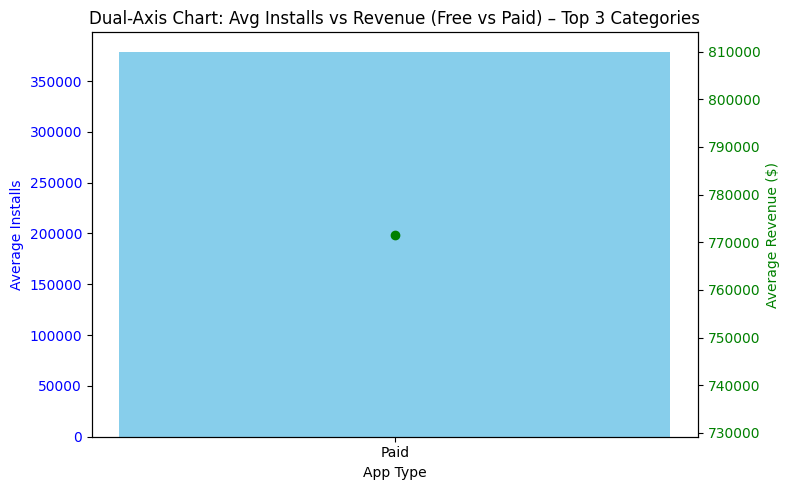

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import pytz

# -------------------- LOAD DATASET --------------------
file_path = r"C:\Users\user\Downloads\Google Playstore Apps.csv"
df = pd.read_csv(file_path)

# -------------------- CLEANING --------------------
df = df.drop_duplicates(subset="App", keep="first")
df["Rating"] = pd.to_numeric(df["Rating"], errors="coerce")
df["Rating"] = df.groupby("Category")["Rating"].transform(lambda x: x.fillna(x.mean()))
df["Reviews"] = pd.to_numeric(df["Reviews"], errors="coerce")
df["Installs"] = df["Installs"].astype(str).str.replace("+","",regex=False).str.replace(",","",regex=False)
df["Installs"] = pd.to_numeric(df["Installs"], errors="coerce")
df["Type"] = df["Type"].fillna(df["Type"].mode()[0])
df["Price"] = df["Price"].astype(str).str.replace("$","",regex=False)
df["Price"] = pd.to_numeric(df["Price"], errors="coerce")
df = df.dropna(subset=["Rating","Installs","Reviews"])

# -------------------- HANDLE MISSING COLUMNS --------------------
df["Content Rating"] = "Everyone"  # placeholder
df["Size_MB"] = 20                  # placeholder >15 MB
df["App_len"] = df["App"].str.len()

# -------------------- ADD REVENUE --------------------
df["Revenue"] = df["Price"] * df["Installs"]

# Android version numeric
def parse_android(ver):
    try:
        return float(ver.split()[0])
    except:
        return np.nan
df["Android Ver Num"] = df["Android Ver"].apply(parse_android)

# -------------------- FILTER TOP 3 CATEGORIES --------------------
top3_cat = df['Category'].value_counts().head(3).index.tolist()

filtered = df[
    (df['Installs'] >= 10000) &
    (df['Revenue'] >= 10000) &
    (df['Android Ver Num'] > 4.0) &
    (df['Size_MB'] > 15) &
    (df['Content Rating'] == "Everyone") &
    (df['App_len'] <= 30) &
    (df['Category'].isin(top3_cat))
]

# -------------------- AGGREGATE FOR DUAL-AXIS --------------------
agg_df = filtered.groupby("Type")[["Installs","Revenue"]].mean()

# -------------------- DUAL-AXIS CHART (SHOW NOW) --------------------
if not agg_df.empty:
    fig, ax1 = plt.subplots(figsize=(8,5))

    # Left axis - Avg Installs
    ax1.bar(agg_df.index, agg_df['Installs'], color='skyblue', label='Avg Installs')
    ax1.set_xlabel('App Type')
    ax1.set_ylabel('Average Installs', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    # Right axis - Avg Revenue
    ax2 = ax1.twinx()
    ax2.plot(agg_df.index, agg_df['Revenue'], color='green', marker='o', linewidth=2, label='Avg Revenue')
    ax2.set_ylabel('Average Revenue ($)', color='green')
    ax2.tick_params(axis='y', labelcolor='green')

    plt.title("Dual-Axis Chart: Avg Installs vs Revenue (Free vs Paid) – Top 3 Categories")
    fig.tight_layout()
    plt.show()
else:
    print("No data available after filtering")